#  Feature Engineering — Rossmann Store Sales

### Objectives
- Handle missing values using domain-aware imputation  
- Engineer date-based and calendar features  
- Create lag features and rolling statistics for time series modeling  
- Build Fourier terms to capture seasonality explicitly  
- Encode categoricals and create interaction features  
- Export final feature set for ARIMA and ML notebooks

## 1. Imports & Config

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import warnings
import os

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams.update({'figure.figsize': (14, 5), 'axes.titlesize': 13})

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Paths
PROCESSED_PATH = '../data/processed/'
RAW_PATH       = '../data/raw/'
FIG_PATH       = '../reports/figures/'
os.makedirs(FIG_PATH, exist_ok=True)

print('Setup complete ✅')

Setup complete ✅


## 2. Load Cleaned Data

In [7]:
df = pd.read_csv(PROCESSED_PATH + 'cleaned_sales_data.csv', parse_dates=['Date'], low_memory=False)

print("Shape of the cleaned sales data:",df.shape)
df.head()

Shape of the cleaned sales data: (844338, 26)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,Year,Month,DayOfMonth,WeekOfYear,MonthName,DayName,HolidayLabel,CompDistBin
0,1,4,2015-07-31,5263,555,1,1,0,1,c,...,NaN,NaN,2015,7,31,31,Jul,Fri,NaN,1-2km
1,2,4,2015-07-31,6064,625,1,1,0,1,a,...,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,Jul,Fri,NaN,500-1km
2,3,4,2015-07-31,8314,821,1,1,0,1,a,...,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,Jul,Fri,NaN,>10km
3,4,4,2015-07-31,13995,1498,1,1,0,1,c,...,NaN,NaN,2015,7,31,31,Jul,Fri,NaN,500-1km
4,5,4,2015-07-31,4822,559,1,1,0,1,a,...,NaN,NaN,2015,7,31,31,Jul,Fri,NaN,>10km


In [8]:
# Quick sanity check on target
print(f"Sales min: {df['Sales'].min():,}")
print(f"Sales max: {df['Sales'].max():,}")
print(f"Null Sales: {df['Sales'].isnull().sum()}")
df.head(3)

Sales min: 46
Sales max: 41,551
Null Sales: 0


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,Year,Month,DayOfMonth,WeekOfYear,MonthName,DayName,HolidayLabel,CompDistBin
0,1,4,2015-07-31,5263,555,1,1,0,1,c,...,NaN,NaN,2015,7,31,31,Jul,Fri,NaN,1-2km
1,2,4,2015-07-31,6064,625,1,1,0,1,a,...,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,Jul,Fri,NaN,500-1km
2,3,4,2015-07-31,8314,821,1,1,0,1,a,...,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,Jul,Fri,NaN,>10km


## 3. Missing Value Imputation

In [9]:
# Before imputation — missing summary
missing_before = df.isnull().sum()
missing_before = missing_before[missing_before > 0].sort_values(ascending=False)
print('Missing values BEFORE imputation:')
print(missing_before)

Missing values BEFORE imputation:
HolidayLabel                 843428
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
CompetitionOpenSinceYear     268600
CompetitionOpenSinceMonth    268600
dtype: int64


In [10]:
# --- CompetitionDistance ---
# Assumption: missing = very far competitor → impute with a large value (max + 1 or 99999)
comp_dist_median = df['CompetitionDistance'].median()
df['CompetitionDistance'].fillna(comp_dist_median, inplace=True)
# Flag that it was missing (can help models learn the pattern)
df['CompDist_WasNull'] = (df['CompetitionDistance'].isnull()).astype(int)

# --- CompetitionOpenSinceMonth / Year ---
df['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
df['CompetitionOpenSinceYear'].fillna(0, inplace=True)

# --- Promo2 related ---
df['Promo2SinceWeek'].fillna(0, inplace=True)
df['Promo2SinceYear'].fillna(0, inplace=True)
df['PromoInterval'].fillna('None', inplace=True)

# After imputation
missing_after = df.isnull().sum()
missing_after = missing_after[missing_after > 0]
print('Missing values AFTER imputation:')
print(missing_after if not missing_after.empty else 'None remaining ✅')

Missing values AFTER imputation:
HolidayLabel    843428
dtype: int64


## 4. Target Variable Transformation

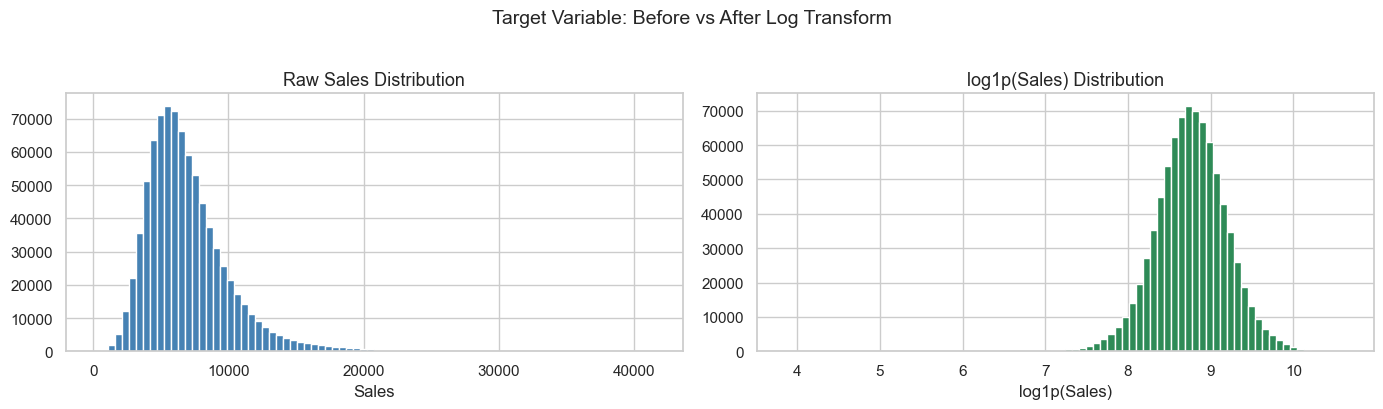

Skewness (raw)     : 1.5949
Skewness (log1p)   : -0.1093


In [11]:
# log1p transform (EDA confirmed right-skew)
df['Sales_log'] = np.log1p(df['Sales'])

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(df['Sales'],      bins=80, color='steelblue', edgecolor='white')
axes[0].set_title('Raw Sales Distribution')
axes[0].set_xlabel('Sales')

axes[1].hist(df['Sales_log'],  bins=80, color='seagreen',  edgecolor='white')
axes[1].set_title('log1p(Sales) Distribution')
axes[1].set_xlabel('log1p(Sales)')

plt.suptitle('Target Variable: Before vs After Log Transform', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIG_PATH + 'target_transform.png', dpi=150)
plt.show()

print(f"Skewness (raw)     : {df['Sales'].skew():.4f}")
print(f"Skewness (log1p)   : {df['Sales_log'].skew():.4f}")

## 5. Date-Based Features

EDA showed strong weekly and monthly seasonality — we extract granular calendar features.

In [12]:
df = df.sort_values(['Store', 'Date']).reset_index(drop=True)

# --- Core calendar features ---
df['Year']          = df['Date'].dt.year
df['Month']         = df['Date'].dt.month
df['Day']           = df['Date'].dt.day
df['DayOfWeek']     = df['Date'].dt.dayofweek          
df['DayOfYear']     = df['Date'].dt.dayofyear
df['WeekOfYear']    = df['Date'].dt.isocalendar().week.astype(int)
df['Quarter']       = df['Date'].dt.quarter

# --- Boolean calendar flags ---
df['IsWeekend']     = (df['DayOfWeek'] >= 5).astype(int)
df['IsMonday']      = (df['DayOfWeek'] == 0).astype(int)   # EDA: Monday peak
df['IsSaturday']    = (df['DayOfWeek'] == 5).astype(int)   # EDA: Saturday lowest

# --- Month position flags ---
df['IsMonthStart']  = (df['Day'] <= 5).astype(int)          # Pay-day effect
df['IsMonthEnd']    = (df['Day'] >= 25).astype(int)

# --- Seasonal flags (based on EDA) ---
df['IsDecember']    = (df['Month'] == 12).astype(int)       # Christmas peak
df['IsQ4']          = (df['Quarter'] == 4).astype(int)

# --- Days to year-end (Christmas proximity) ---
df['DaysToYearEnd'] = df['Date'].apply(
    lambda d: (pd.Timestamp(d.year, 12, 31) - d).days
)

print('Date features created:')
date_cols = ['Year','Month','Day','DayOfWeek','DayOfYear','WeekOfYear','Quarter',
             'IsWeekend','IsMonday','IsSaturday','IsMonthStart','IsMonthEnd',
             'IsDecember','IsQ4','DaysToYearEnd']
print(df[date_cols].head(3))

Date features created:
   Year  Month  Day  DayOfWeek  DayOfYear  WeekOfYear  Quarter  IsWeekend  \
0  2013      1    2          2          2           1        1          0   
1  2013      1    3          3          3           1        1          0   
2  2013      1    4          4          4           1        1          0   

   IsMonday  IsSaturday  IsMonthStart  IsMonthEnd  IsDecember  IsQ4  \
0         0           0             1           0           0     0   
1         0           0             1           0           0     0   
2         0           0             1           0           0     0   

   DaysToYearEnd  
0            363  
1            362  
2            361  


## 6. Fourier Terms — Capturing Seasonality Explicitly

Fourier features encode periodicity mathematically — used directly in regression/ML models and as exogenous regressors in ARIMA.

Fourier features created: 12
['fourier_weekly_sin_7_1', 'fourier_weekly_cos_7_1', 'fourier_weekly_sin_7_2', 'fourier_weekly_cos_7_2', 'fourier_weekly_sin_7_3', 'fourier_weekly_cos_7_3', 'fourier_annual_sin_365_1', 'fourier_annual_cos_365_1', 'fourier_annual_sin_365_2', 'fourier_annual_cos_365_2', 'fourier_annual_sin_365_3', 'fourier_annual_cos_365_3']


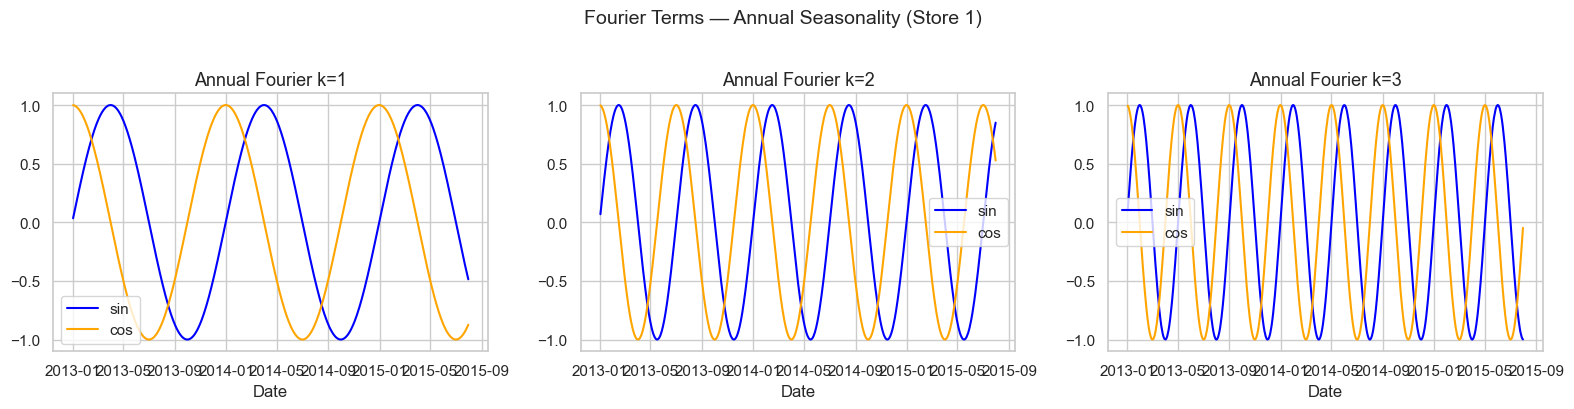

In [13]:
def add_fourier_terms(df, period, n_terms, col='DayOfYear', prefix='fourier'):
    """Add sin/cos Fourier pairs for a given period."""
    for k in range(1, n_terms + 1):
        df[f'{prefix}_sin_{period}_{k}'] = np.sin(2 * np.pi * k * df[col] / period)
        df[f'{prefix}_cos_{period}_{k}'] = np.cos(2 * np.pi * k * df[col] / period)
    return df

# Weekly seasonality (period=7) — 3 Fourier pairs
df = add_fourier_terms(df, period=7,   n_terms=3, col='DayOfWeek', prefix='fourier_weekly')
# Annual seasonality (period=365) — 3 Fourier pairs
df = add_fourier_terms(df, period=365, n_terms=3, col='DayOfYear',  prefix='fourier_annual')

fourier_cols = [c for c in df.columns if 'fourier' in c]
print(f'Fourier features created: {len(fourier_cols)}')
print(fourier_cols)

# Visualise Fourier terms for annual seasonality
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sample_store = df[df['Store'] == 1].sort_values('Date')
for i, k in enumerate(range(1, 4)):
    axes[i].plot(sample_store['Date'], sample_store[f'fourier_annual_sin_365_{k}'], label='sin', color='blue')
    axes[i].plot(sample_store['Date'], sample_store[f'fourier_annual_cos_365_{k}'], label='cos', color='orange')
    axes[i].set_title(f'Annual Fourier k={k}')
    axes[i].set_xlabel('Date')
    axes[i].legend()
plt.suptitle('Fourier Terms — Annual Seasonality (Store 1)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIG_PATH + 'fourier_terms.png', dpi=150)
plt.show()

## 7. Lag Features

Lag features capture **autocorrelation** in the series — critical for time series ML models.  
We create per-store lags to avoid data leakage across stores.

In [14]:
df = df.sort_values(['Store', 'Date']).reset_index(drop=True)

LAG_DAYS = [1, 2, 3, 7, 14, 21, 28]  # 1-3 days, 1 week, 2 weeks, 3 weeks, 4 weeks

for lag in LAG_DAYS:
    df[f'Sales_lag_{lag}'] = df.groupby('Store')['Sales'].shift(lag)
    df[f'LogSales_lag_{lag}'] = df.groupby('Store')['Sales_log'].shift(lag)

lag_cols = [c for c in df.columns if 'Sales_lag' in c]
print(f'Lag features created: {len(lag_cols)}')
print(f'Sample (Store 1, first rows with data):')
df[df['Store'] == 1][['Date', 'Sales', 'Sales_lag_1', 'Sales_lag_7', 'Sales_lag_28']].dropna().head(5)

Lag features created: 14
Sample (Store 1, first rows with data):


,Date,Sales,Sales_lag_1,Sales_lag_7,Sales_lag_28
28,2013-02-04,7032,5970.0,5598.0,5530.0
29,2013-02-05,6049,7032.0,4055.0,4327.0
30,2013-02-06,6140,6049.0,3725.0,4486.0
31,2013-02-07,5499,6140.0,4601.0,4997.0
32,2013-02-08,5681,5499.0,4709.0,7176.0


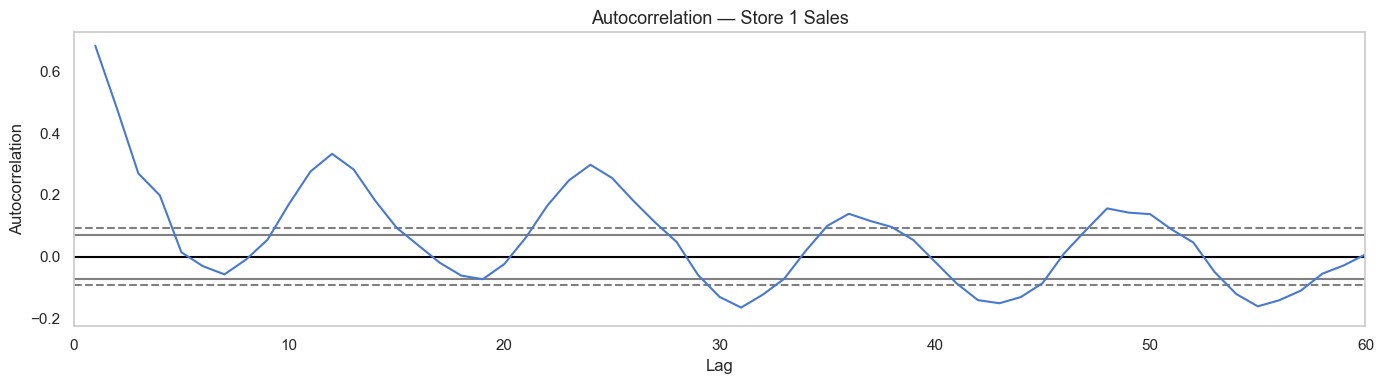

In [15]:
# Autocorrelation plot to validate lag choices
from pandas.plotting import autocorrelation_plot

store1_sales = df[df['Store'] == 1].sort_values('Date')['Sales'].dropna()

fig, ax = plt.subplots(figsize=(14, 4))
autocorrelation_plot(store1_sales, ax=ax)
ax.set_title('Autocorrelation — Store 1 Sales')
ax.set_xlim(0, 60)
plt.tight_layout()
plt.savefig(FIG_PATH + 'autocorrelation.png', dpi=150)
plt.show()

## 8. Rolling Window Statistics

Rolling features capture **local trends and volatility** — the model can learn smoothed patterns without overfitting to single-day noise.

In [16]:
WINDOWS = [7, 14, 28]   # 1 week, 2 weeks, 4 weeks

for w in WINDOWS:
    # Shift by 1 first to avoid look-ahead leakage
    shifted = df.groupby('Store')['Sales'].shift(1)
    rolling_grp = shifted.groupby(df['Store'])

    df[f'Sales_roll_mean_{w}'] = rolling_grp.transform(lambda x: x.rolling(w, min_periods=1).mean())
    df[f'Sales_roll_std_{w}']  = rolling_grp.transform(lambda x: x.rolling(w, min_periods=1).std())
    df[f'Sales_roll_max_{w}']  = rolling_grp.transform(lambda x: x.rolling(w, min_periods=1).max())
    df[f'Sales_roll_min_{w}']  = rolling_grp.transform(lambda x: x.rolling(w, min_periods=1).min())

# Exponentially weighted mean (captures recent trends more)
df['Sales_ewm_7']  = df.groupby('Store')['Sales'].transform(lambda x: x.shift(1).ewm(span=7).mean())
df['Sales_ewm_28'] = df.groupby('Store')['Sales'].transform(lambda x: x.shift(1).ewm(span=28).mean())

roll_cols = [c for c in df.columns if 'roll' in c or 'ewm' in c]
print(f'Rolling features created: {len(roll_cols)}')
print(roll_cols)

Rolling features created: 14
['Sales_roll_mean_7', 'Sales_roll_std_7', 'Sales_roll_max_7', 'Sales_roll_min_7', 'Sales_roll_mean_14', 'Sales_roll_std_14', 'Sales_roll_max_14', 'Sales_roll_min_14', 'Sales_roll_mean_28', 'Sales_roll_std_28', 'Sales_roll_max_28', 'Sales_roll_min_28', 'Sales_ewm_7', 'Sales_ewm_28']


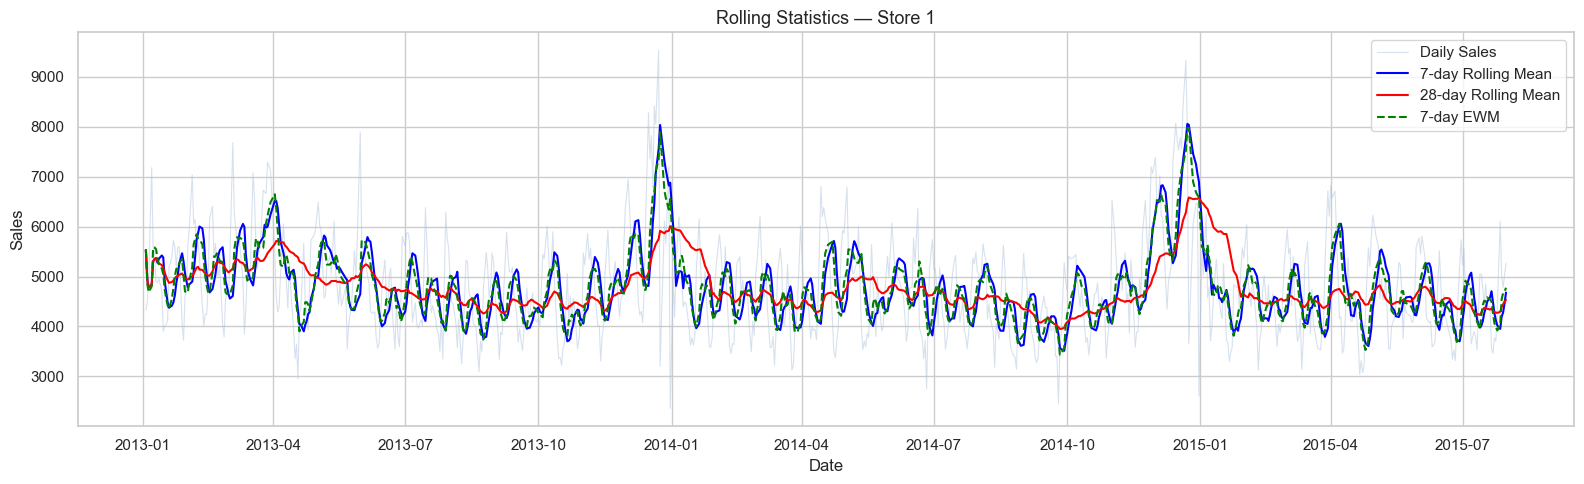

In [17]:
# Visualise rolling features for Store 1
s1 = df[df['Store'] == 1].sort_values('Date').dropna(subset=['Sales_roll_mean_7'])

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(s1['Date'], s1['Sales'],              color='lightsteelblue', alpha=0.5, linewidth=0.8, label='Daily Sales')
ax.plot(s1['Date'], s1['Sales_roll_mean_7'],  color='blue',  linewidth=1.5, label='7-day Rolling Mean')
ax.plot(s1['Date'], s1['Sales_roll_mean_28'], color='red',   linewidth=1.5, label='28-day Rolling Mean')
ax.plot(s1['Date'], s1['Sales_ewm_7'],        color='green', linewidth=1.5, linestyle='--', label='7-day EWM')
ax.set_title('Rolling Statistics — Store 1')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
plt.tight_layout()
plt.savefig(FIG_PATH + 'rolling_features.png', dpi=150)
plt.show()

## 9. Competition Features

In [18]:
# log-transform CompetitionDistance (EDA: non-linear effect)
df['CompDist_log'] = np.log1p(df['CompetitionDistance'])

# Months competitor has been open
df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].astype(int)
df['CompetitionOpenSinceYear']  = df['CompetitionOpenSinceYear'].astype(int)

df['CompOpen_Months'] = np.where(
    df['CompetitionOpenSinceYear'] > 0,
    (df['Year']  - df['CompetitionOpenSinceYear']) * 12 +
    (df['Month'] - df['CompetitionOpenSinceMonth']),
    -1   # -1 = no competitor / unknown
)
df['CompOpen_Months'] = df['CompOpen_Months'].clip(lower=-1)

# Flag: has active competitor
df['HasCompetitor'] = (df['CompetitionOpenSinceYear'] > 0).astype(int)

print('Competition features created:')
print(df[['Store','Date','CompetitionDistance','CompDist_log','CompOpen_Months','HasCompetitor']].head(5))

Competition features created:
   Store       Date  CompetitionDistance  CompDist_log  CompOpen_Months  \
0      1 2013-01-02               1270.0      7.147559               52   
1      1 2013-01-03               1270.0      7.147559               52   
2      1 2013-01-04               1270.0      7.147559               52   
3      1 2013-01-05               1270.0      7.147559               52   
4      1 2013-01-07               1270.0      7.147559               52   

   HasCompetitor  
0              1  
1              1  
2              1  
3              1  
4              1  


## 10. Promo2 Features

Promo2 is a long-running promotion. We engineer whether a given month is an active Promo2 month for each store.

In [20]:
# Ensure Date column is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Replace 0 with NaN to avoid invalid date creation
df['Promo2SinceYear'] = df['Promo2SinceYear'].replace(0, np.nan)
df['Promo2SinceWeek'] = df['Promo2SinceWeek'].replace(0, np.nan)

# Create Promo2 Start Date using ISO year + week (Monday of that week)
df['Promo2StartDate'] = pd.to_datetime(
    df['Promo2SinceYear'].astype('Int64').astype(str) +
    df['Promo2SinceWeek'].astype('Int64').astype(str) +
    '1',                      # 1 = Monday
    format='%G%V%u',
    errors='coerce'
)

# Weeks Since Promo2 Started
df['WeeksSincePromo2'] = np.where(
    df['Promo2StartDate'].notna(),
    (df['Date'] - df['Promo2StartDate']).dt.days // 7,
    -1
)

df['WeeksSincePromo2'] = df['WeeksSincePromo2'].clip(lower=-1)


# ------------------------------
# Promo2 Active Feature (Vectorized — no apply)
# ------------------------------

promo_month_map = {
    'Jan,Apr,Jul,Oct': [1, 4, 7, 10],
    'Feb,May,Aug,Nov': [2, 5, 8, 11],
    'Mar,Jun,Sept,Dec': [3, 6, 9, 12]
}

# Extract month if not already present
df['Month'] = df['Date'].dt.month

# Map PromoInterval to active months
df['PromoMonths'] = df['PromoInterval'].map(promo_month_map)

df['IsPromo2Active'] = np.where(
    (df['Promo2'] == 1) &
    (df['Promo2StartDate'].notna()) &
    (df['Date'] >= df['Promo2StartDate']) &
    (df.apply(lambda x: x['Month'] in x['PromoMonths'] if isinstance(x['PromoMonths'], list) else False, axis=1)),
    1,
    0
)

# Optional: Drop helper column
df.drop(columns=['PromoMonths'], inplace=True)

print("IsPromo2Active distribution:")
print(df['IsPromo2Active'].value_counts())

IsPromo2Active distribution:
IsPromo2Active
0    717970
1    126368
Name: count, dtype: int64


## 11. Holiday Features

In [21]:
# Encode StateHoliday
holiday_map = {'0': 0, 0: 0, 'a': 1, 'b': 2, 'c': 3}
df['StateHoliday_enc'] = df['StateHoliday'].astype(str).map({
    '0': 0, 'a': 1, 'b': 2, 'c': 3
}).fillna(0).astype(int)

df['IsPublicHoliday']  = (df['StateHoliday_enc'] == 1).astype(int)
df['IsEasterHoliday']  = (df['StateHoliday_enc'] == 2).astype(int)
df['IsChristmas']      = (df['StateHoliday_enc'] == 3).astype(int)
df['IsAnyHoliday']     = (df['StateHoliday_enc'] > 0).astype(int)

# Days before/after holiday (±3 day window)
df_sorted = df.sort_values(['Store', 'Date']).reset_index(drop=True)

for offset, name in [(-1, 'BeforeHoliday'), (1, 'AfterHoliday')]:
    df_sorted[name] = df_sorted.groupby('Store')['IsAnyHoliday'].shift(offset).fillna(0).astype(int)

df = df_sorted.copy()
print('Holiday features created ✅')
print(df[['Date','StateHoliday','StateHoliday_enc','IsPublicHoliday','IsChristmas','BeforeHoliday','AfterHoliday']].head(8))

Holiday features created ✅
        Date StateHoliday  StateHoliday_enc  IsPublicHoliday  IsChristmas  \
0 2013-01-02            0                 0                0            0   
1 2013-01-03            0                 0                0            0   
2 2013-01-04            0                 0                0            0   
3 2013-01-05            0                 0                0            0   
4 2013-01-07            0                 0                0            0   
5 2013-01-08            0                 0                0            0   
6 2013-01-09            0                 0                0            0   
7 2013-01-10            0                 0                0            0   

   BeforeHoliday  AfterHoliday  
0              0             0  
1              0             0  
2              0             0  
3              0             0  
4              0             0  
5              0             0  
6              0             0  
7              

## 12. Categorical Encoding

**EDA insight:** Type b stores have highest avg sales → ordinal encoding by performance makes sense.

In [22]:
# StoreType: one-hot encoding
df = pd.get_dummies(df, columns=['StoreType'], prefix='StoreType', drop_first=False)

# Assortment: ordinal (a=basic=1, b=extra=3, c=extended=2, based on EDA ranking)
assortment_rank = {'a': 1, 'b': 3, 'c': 2}
df['Assortment_enc'] = df['Assortment'].map(assortment_rank).fillna(1).astype(int)

# DayOfWeek: one-hot (strong per-day effects from EDA)
df = pd.get_dummies(df, columns=['DayOfWeek'], prefix='DayOfWeek', drop_first=False)

# Month: cyclical encoding (preserves distance between Dec and Jan)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Week of Year: cyclical
df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)

print('Categorical encoding done ✅')
store_type_cols  = [c for c in df.columns if 'StoreType' in c]
dow_cols         = [c for c in df.columns if 'DayOfWeek_' in c]
print(f'StoreType dummies : {store_type_cols}')
print(f'DayOfWeek dummies : {dow_cols}')

Categorical encoding done ✅
StoreType dummies : ['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d']
DayOfWeek dummies : ['DayOfWeek_0', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6']


## 13. Interaction Features

Interactions capture combined effects — e.g., Promo on a Monday might have outsized impact.

In [23]:
# Promo × Day interactions
df['Promo_x_Monday']      = df['Promo'] * df['IsMonday']
df['Promo_x_Weekend']     = df['Promo'] * df['IsWeekend']
df['Promo_x_SchoolHol']   = df['Promo'] * df['SchoolHoliday']
df['Promo_x_Promo2']      = df['Promo'] * df['IsPromo2Active']

# Holiday × Weekend
df['Holiday_x_Weekend']   = df['IsAnyHoliday'] * df['IsWeekend']

# Q4 × Promo (Christmas + promotions)
df['Q4_x_Promo']          = df['IsQ4'] * df['Promo']

# Assortment × CompDistance (richer stores may attract more customers despite competition)
df['Assort_x_CompDist']   = df['Assortment_enc'] * df['CompDist_log']

interaction_cols = ['Promo_x_Monday','Promo_x_Weekend','Promo_x_SchoolHol',
                    'Promo_x_Promo2','Holiday_x_Weekend','Q4_x_Promo','Assort_x_CompDist']
print(f'Interaction features created: {len(interaction_cols)}')
print(df[interaction_cols].describe())

Interaction features created: 7
       Promo_x_Monday  Promo_x_Weekend  Promo_x_SchoolHol  Promo_x_Promo2  \
count   844338.000000         844338.0      844338.000000   844338.000000   
mean         0.091482              0.0           0.092095        0.067703   
std          0.288294              0.0           0.289160        0.251235   
min          0.000000              0.0           0.000000        0.000000   
25%          0.000000              0.0           0.000000        0.000000   
50%          0.000000              0.0           0.000000        0.000000   
75%          0.000000              0.0           0.000000        0.000000   
max          1.000000              0.0           1.000000        1.000000   

       Holiday_x_Weekend     Q4_x_Promo  Assort_x_CompDist  
count      844338.000000  844338.000000      844338.000000  
mean            0.000009       0.080544          11.458417  
std             0.003078       0.272133           4.921260  
min             0.000000      

## 14. Store-Level Aggregate Features

Encode **store-level historical statistics** as features — captures store-specific baselines.

In [24]:
# Use only training data to compute aggregates (to avoid leakage)
store_stats = df.groupby('Store')['Sales'].agg(
    Store_SalesMean   = 'mean',
    Store_SalesMedian = 'median',
    Store_SalesStd    = 'std',
    Store_SalesMax    = 'max',
    Store_SalesMin    = 'min'
).reset_index()

df = df.merge(store_stats, on='Store', how='left')

# Store promo rate
store_promo = df.groupby('Store')['Promo'].mean().reset_index().rename(columns={'Promo': 'Store_PromoRate'})
df = df.merge(store_promo, on='Store', how='left')

print('Store aggregate features created:')
store_agg_cols = ['Store_SalesMean','Store_SalesMedian','Store_SalesStd',
                  'Store_SalesMax','Store_SalesMin','Store_PromoRate']
print(df[store_agg_cols].head(3))

Store aggregate features created:
   Store_SalesMean  Store_SalesMedian  Store_SalesStd  Store_SalesMax  \
0      4759.096031             4647.0     1012.106393            9528   
1      4759.096031             4647.0     1012.106393            9528   
2      4759.096031             4647.0     1012.106393            9528   

   Store_SalesMin  Store_PromoRate  
0            2362         0.448143  
1            2362         0.448143  
2            2362         0.448143  


## 15. Feature Summary & Analysis

Total features available: 108

Feature count by category:
Category
Date/Cal       34
Lag            14
Rolling        14
Fourier        12
Holiday         8
Promo           8
Store Agg       5
Competition     5
Other           4
StoreType       4
Name: count, dtype: int64


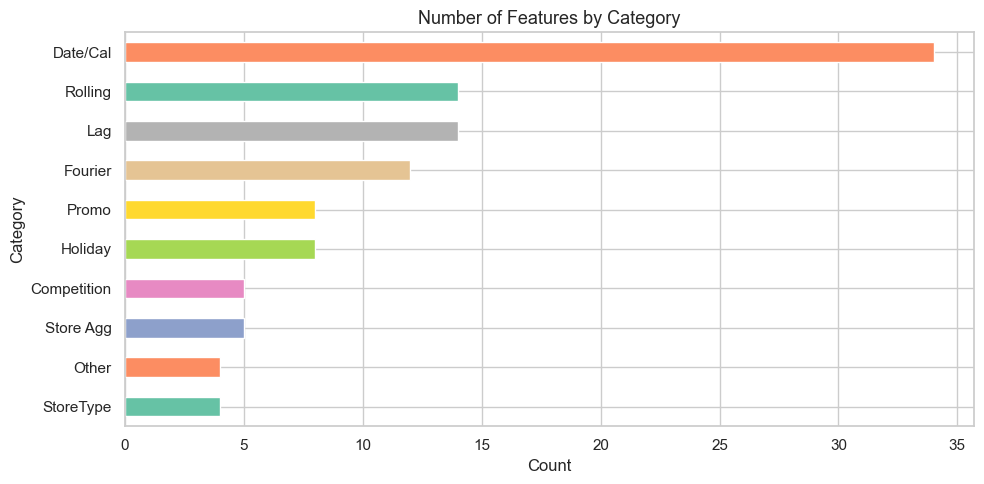

In [25]:
# All engineered features
exclude_cols = ['Date', 'Sales', 'Sales_log', 'StateHoliday', 'PromoInterval',
                'Assortment', 'MonthName', 'DayName', 'HolidayLabel']
feature_cols = [c for c in df.columns if c not in exclude_cols
                and df[c].dtype in [np.float64, np.int64, np.int32, np.float32, bool, int, float]]

print(f'Total features available: {len(feature_cols)}')
feature_df = pd.DataFrame({'Feature': feature_cols})
feature_df['Category'] = feature_df['Feature'].apply(lambda f:
    'Lag'         if 'lag' in f else
    'Rolling'     if 'roll' in f or 'ewm' in f else
    'Fourier'     if 'fourier' in f else
    'Date/Cal'    if any(x in f for x in ['Year','Month','Day','Week','Quarter','IsMonday','IsSaturday','IsWeekend','IsMonth','IsDecember','IsQ4','DaysToYear']) else
    'Promo'       if 'Promo' in f or 'promo' in f else
    'Holiday'     if 'Holiday' in f or 'holiday' in f or 'Christmas' in f or 'Easter' in f else
    'Competition' if 'Comp' in f else
    'StoreType'   if 'StoreType' in f else
    'Interaction' if '_x_' in f else
    'Store Agg'   if 'Store_' in f else
    'Other'
)

category_counts = feature_df['Category'].value_counts()
print('\nFeature count by category:')
print(category_counts)

fig, ax = plt.subplots(figsize=(10, 5))
category_counts.sort_values().plot(kind='barh', ax=ax, color=sns.color_palette('Set2', len(category_counts)))
ax.set_title('Number of Features by Category')
ax.set_xlabel('Count')
plt.tight_layout()
plt.savefig(FIG_PATH + 'feature_categories.png', dpi=150)
plt.show()

Computing Spearman correlations with Sales...


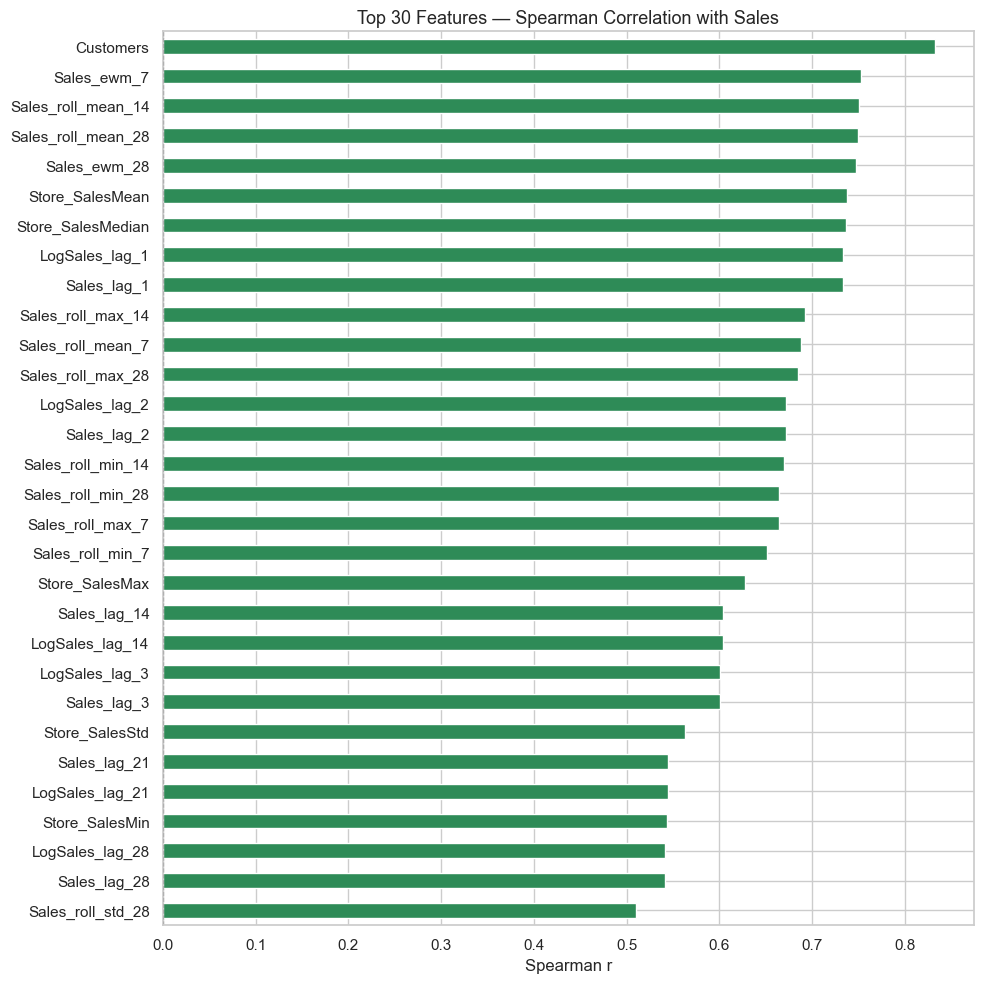

In [26]:
# Spearman correlation of features with Sales
# (Spearman handles non-linearity better than Pearson — good for CompDist)
print('Computing Spearman correlations with Sales...')

sample = df.dropna(subset=['Sales']).sample(min(50000, len(df)), random_state=RANDOM_SEED)

corr_dict = {}
for col in feature_cols:
    try:
        r, p = spearmanr(sample[col].fillna(0), sample['Sales'])
        corr_dict[col] = r
    except:
        pass

corr_series = pd.Series(corr_dict).sort_values(key=abs, ascending=False)
top_features = corr_series.head(30)

fig, ax = plt.subplots(figsize=(10, 10))
colors = ['seagreen' if v > 0 else 'tomato' for v in top_features.values]
top_features.sort_values().plot(kind='barh', ax=ax, color=colors)
ax.axvline(0, color='black', linewidth=0.8, linestyle='--')
ax.set_title('Top 30 Features — Spearman Correlation with Sales', fontsize=13)
ax.set_xlabel('Spearman r')
plt.tight_layout()
plt.savefig(FIG_PATH + 'feature_importance_corr.png', dpi=150)
plt.show()

## 16. Train / Validation Split

**Time-based split** — never random! For time series, we must train on past and validate on future.

Split date     : 2015-01-30
Train records  : 675,958  | 2013-01-01 → 2015-01-30
Val   records  : 168,380    | 2015-01-31 → 2015-07-31


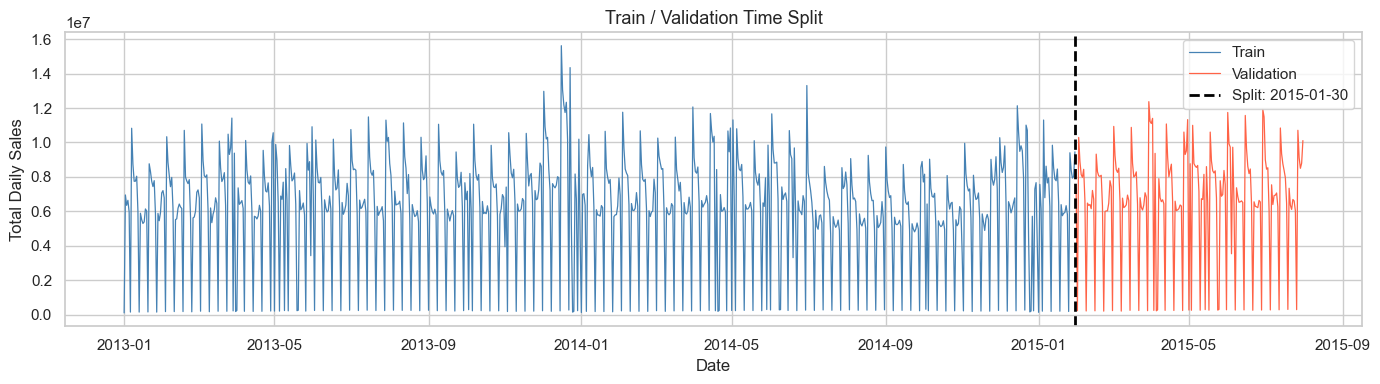

In [27]:
# 80/20 time split
split_date = df['Date'].quantile(0.80)
# Snap to nearest day
split_date = pd.Timestamp(split_date)

train_df = df[df['Date'] <= split_date].copy()
val_df   = df[df['Date']  > split_date].copy()

print(f'Split date     : {split_date.date()}')
print(f'Train records  : {len(train_df):,}  | {train_df.Date.min().date()} → {train_df.Date.max().date()}')
print(f'Val   records  : {len(val_df):,}    | {val_df.Date.min().date()} → {val_df.Date.max().date()}')

fig, ax = plt.subplots(figsize=(14, 4))
daily = df.groupby('Date')['Sales'].sum()
train_daily = train_df.groupby('Date')['Sales'].sum()
val_daily   = val_df.groupby('Date')['Sales'].sum()

ax.plot(train_daily.index, train_daily.values, color='steelblue', label='Train', linewidth=0.9)
ax.plot(val_daily.index,   val_daily.values,   color='tomato',    label='Validation', linewidth=0.9)
ax.axvline(split_date, color='black', linewidth=2, linestyle='--', label=f'Split: {split_date.date()}')
ax.set_title('Train / Validation Time Split')
ax.set_xlabel('Date')
ax.set_ylabel('Total Daily Sales')
ax.legend()
plt.tight_layout()
plt.savefig(FIG_PATH + 'train_val_split.png', dpi=150)
plt.show()

## 17. Final Feature Set Selection & Export

In [28]:
# Define final columns to keep
KEEP_COLS = (
    # Identifiers
    ['Store', 'Date', 'Sales', 'Sales_log']
    # Core features
    + ['Promo', 'Promo2', 'IsPromo2Active', 'WeeksSincePromo2', 'Promo_x_Monday',
       'Promo_x_Weekend', 'Promo_x_SchoolHol', 'Promo_x_Promo2', 'Q4_x_Promo']
    # Date features
    + ['Year', 'Month', 'Day', 'DayOfYear', 'WeekOfYear', 'Quarter',
       'IsWeekend', 'IsMonday', 'IsSaturday', 'IsMonthStart', 'IsMonthEnd',
       'IsDecember', 'IsQ4', 'DaysToYearEnd']
    # Cyclical
    + ['Month_sin', 'Month_cos', 'WeekOfYear_sin', 'WeekOfYear_cos']
    # Fourier
    + [c for c in df.columns if 'fourier' in c]
    # Lag
    + [f'Sales_lag_{l}' for l in LAG_DAYS]
    + [f'LogSales_lag_{l}' for l in LAG_DAYS]
    # Rolling
    + [f'Sales_roll_mean_{w}' for w in WINDOWS]
    + [f'Sales_roll_std_{w}'  for w in WINDOWS]
    + ['Sales_ewm_7', 'Sales_ewm_28']
    # Competition
    + ['CompetitionDistance', 'CompDist_log', 'CompOpen_Months', 'HasCompetitor',
       'Assort_x_CompDist']
    # Holiday
    + ['SchoolHoliday', 'StateHoliday_enc', 'IsPublicHoliday', 'IsEasterHoliday',
       'IsChristmas', 'IsAnyHoliday', 'BeforeHoliday', 'AfterHoliday', 'Holiday_x_Weekend']
    # Store type
    + [c for c in df.columns if 'StoreType_' in c]
    + ['Assortment_enc']
    # DayOfWeek dummies
    + [c for c in df.columns if 'DayOfWeek_' in c]
    # Store aggregates
    + store_agg_cols
    # Null flags
    + ['CompDist_WasNull']
)

# Keep only columns that exist in df
KEEP_COLS = [c for c in KEEP_COLS if c in df.columns]
KEEP_COLS = list(dict.fromkeys(KEEP_COLS))  # deduplicate while preserving order

df_final = df[KEEP_COLS].copy()
print(f'Final dataset shape: {df_final.shape}')
print(f'Total features     : {len(KEEP_COLS) - 4}  (excluding Store, Date, Sales, Sales_log)')

Final dataset shape: (844338, 98)
Total features     : 94  (excluding Store, Date, Sales, Sales_log)


In [29]:
# Check remaining nulls (from lag features at start of each store's history)
null_summary = df_final.isnull().sum()
null_summary = null_summary[null_summary > 0].sort_values(ascending=False)
print('Null counts in final dataset (expected from lags):')
print(null_summary)

Null counts in final dataset (expected from lags):
LogSales_lag_28       31220
Sales_lag_28          31220
Sales_lag_21          23415
LogSales_lag_21       23415
LogSales_lag_14       15610
Sales_lag_14          15610
LogSales_lag_7         7805
Sales_lag_7            7805
Sales_lag_3            3345
LogSales_lag_3         3345
Sales_roll_std_28      2230
Sales_lag_2            2230
LogSales_lag_2         2230
Sales_roll_std_7       2230
Sales_roll_std_14      2230
Sales_lag_1            1115
LogSales_lag_1         1115
Sales_roll_mean_7      1115
Sales_roll_mean_28     1115
Sales_roll_mean_14     1115
Sales_ewm_7            1115
Sales_ewm_28           1115
dtype: int64


In [30]:
# Save full featured dataset
df_final.to_csv(PROCESSED_PATH + 'featured_sales_data.csv', index=False)

# Save train/val splits
train_final = df_final[df_final['Date'] <= split_date]
val_final   = df_final[df_final['Date']  > split_date]
train_final.to_csv(PROCESSED_PATH + 'train_featured.csv', index=False)
val_final.to_csv(PROCESSED_PATH + 'val_featured.csv',   index=False)

# Save feature list for use in other notebooks
feature_list = [c for c in KEEP_COLS if c not in ['Store','Date','Sales','Sales_log']]
pd.Series(feature_list).to_csv(PROCESSED_PATH + 'feature_list.csv', index=False, header=['feature'])

print('Saved to data/processed/:')
print('  ✅ featured_sales_data.csv')
print('  ✅ train_featured.csv')
print('  ✅ val_featured.csv')
print('  ✅ feature_list.csv')
print(f'\nTrain: {len(train_final):,} rows  |  Val: {len(val_final):,} rows')

Saved to data/processed/:
  ✅ featured_sales_data.csv
  ✅ train_featured.csv
  ✅ val_featured.csv
  ✅ feature_list.csv

Train: 675,958 rows  |  Val: 168,380 rows


## 18. Feature Engineering Summary

## Imputation                                                              
• CompetitionDistance → median fill + WasNull flag                      
• CompetitionOpenSince, Promo2Since → 0 fill (no competitor/promo)      
• PromoInterval → 'None' fill 

## Target                                                                  
• Sales_log = log1p(Sales)   [reduces right-skew]  

## Date / Calendar                                                         
• Year, Month, Day, DayOfYear, WeekOfYear, Quarter                      
• IsWeekend, IsMonday, IsSaturday, IsMonthStart/End, IsDecember, IsQ4   
• DaysToYearEnd (Christmas proximity)                                   
• Month_sin/cos, WeekOfYear_sin/cos (cyclical encoding) 

## Fourier Terms                                                           
• Weekly seasonality: 3 sin/cos pairs (period=7)                        
• Annual seasonality: 3 sin/cos pairs (period=365) 

## Lag Features (per store, no leakage)                                    
• Sales & log(Sales): lags 1,2,3,7,14,21,28 days

## Rolling Statistics (shifted by 1 to prevent leakage)                   
• 7, 14, 28-day: mean, std, max, min                                   
• EWM span=7 and span=28 

## Competition                                                             
• log1p(CompetitionDistance), CompOpen_Months, HasCompetitor

## Promo                                                                   
• IsPromo2Active, WeeksSincePromo2                                      
• Promo × {Monday, Weekend, SchoolHol, Promo2, Q4}

## Holidays                                                                
• StateHoliday_enc, IsPublicHoliday, IsEasterHoliday, IsChristmas       
• BeforeHoliday, AfterHoliday (±1 day window)

## Categoricals                                                            
• StoreType → one-hot (4 dummies)                                       
• Assortment → ordinal rank (b=3 > c=2 > a=1, from EDA)                
• DayOfWeek → one-hot (7 dummies) 

## Store Aggregates                                                        
• Per-store: mean, median, std, max, min sales; promo rate 